In [36]:
import autograd
import autograd.numpy as ag_np
import numpy as np
import matplotlib.pyplot as plt
from autograd.scipy.special import expit as ag_expit
import scipy.optimize
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors
import os
import pandas as pd
%matplotlib inline

## Create Toy Data

In [2]:
# create the toy dataset with positive and negative examples from the paper
D=2
pos_means = [[1.0, 1.0],
             [1.0, 2.5]]

pos_covs = [0.1*np.eye(D), 
            0.06*np.eye(D)]

pos_samples_n = [200, 25]

neg_means = [[2.25, 1.5],
            [0.0, 0.5],
            [0.0, 3]]

neg_covs = [0.1*np.eye(D),
           0.05*np.eye(D),
           0.05*np.eye(D)]

neg_samples_n = [300, 20, 20]

prng = np.random.RandomState(201)
x_pos_list = []
for i in range(len(pos_means)):
    x_pos_list.append(prng.multivariate_normal(pos_means[i], pos_covs[i], pos_samples_n[i]))

x_pos_ND = np.vstack(x_pos_list)
y_pos_N = np.ones((len(x_pos_ND)))

x_neg_list = []
for i in range(len(neg_means)):
    x_neg_list.append(prng.multivariate_normal(neg_means[i], neg_covs[i], neg_samples_n[i]))
    
x_neg_ND = np.vstack(x_neg_list)
y_neg_N = np.zeros((len(x_neg_ND)))

x_ND = np.vstack([x_pos_ND, x_neg_ND])
y_N = np.hstack([y_pos_N, y_neg_N])

prng = np.random.RandomState(0)
shuffle_ids = prng.permutation(y_N.size)
train_x_ND = x_ND[shuffle_ids]
train_y_N = y_N[shuffle_ids]

# for i in range(D):
#     den = np.max(train_x_ND[:,i]) - np.min(train_x_ND[:,i])
#     train_x_ND[:, i] = (train_x_ND[:,i] - np.min(train_x_ND[:,i]))/den


In [3]:
f, axs = plt.subplots(1, 1)
axs.plot(x_pos_ND[:,0], x_pos_ND[:,1], 'r+')
axs.plot(x_neg_ND[:,0], x_neg_ND[:,1], 'bx')
axs.grid(True)
plt.show()

## Load the mimic collapsed features and get heart rate and BP

In [26]:
collapsed_data_folder = '/cluster/tufts/hugheslab/prath01/projects/time_series_prediction/datasets/mimic3_inhospital_mortality/v20201207/split-by=subject_id/collapsed_features_per_sequence/'
outcomes_folder = '/cluster/tufts/hugheslab/prath01/projects/time_series_prediction/datasets/mimic3_inhospital_mortality/v20201207/'
f_path = os.path.join(collapsed_data_folder, 'CollapsedFeaturesPerSequence.csv')
outcomes_path = os.path.join(outcomes_folder, 'outcomes_per_seq.csv')

collapsed_df = pd.read_csv(f_path)
outcomes_df = pd.read_csv(outcomes_path)

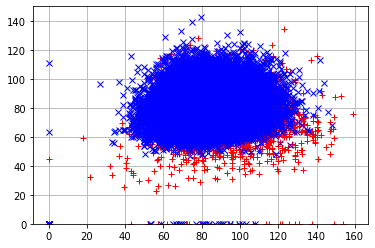

In [39]:
feature_cols = ['heart rate_median_50%_to_100%', 'mean blood pressure_median_50%_to_100%']
id_cols = ['subject_id', 'hadm_id', 'icustay_id']
outcome_col = ['mort_hosp']

collapsed_df = collapsed_df[id_cols+feature_cols]
features_outcomes_df = pd.merge(collapsed_df, outcomes_df, how='inner')

x_ND = features_outcomes_df[feature_cols].values
y_N = features_outcomes_df['mort_hosp'].values

x_pos_ND = x_ND[y_N==1]
x_neg_ND = x_ND[y_N==0]
y_pos_N = np.ones((len(x_pos_ND)))
y_neg_N = np.zeros((len(x_neg_ND)))

prng = np.random.RandomState(0)
shuffle_ids = prng.permutation(y_N.size)
train_x_ND = x_ND[shuffle_ids]
train_y_N = y_N[shuffle_ids]

f, axs = plt.subplots(1, 1)
axs.plot(x_pos_ND[:,0], x_pos_ND[:,1], 'r+')
axs.plot(x_neg_ND[:,0], x_neg_ND[:,1], 'bx')
axs.set_ylim([0, 150])
axs.grid(True)
plt.show()

## Train Logistic Regression optimizing cross entropy

In [40]:
def calc_decision_score(x, w):
    return ag_np.dot(x, w[:2]) + w[2]

def calc_cross_entropy_loss(w_D):  
    ry_N = ag_np.sign(y_N-0.01)*(ag_np.dot(x_ND, w_D[:2]) + w_D[2])
    cross_ent = ag_np.sum(ag_np.log(ag_expit(ry_N)+1e-15))# add 1e-15 to avoid precision problems
    return -1.0*cross_ent



grad_cross_entropy_loss = autograd.grad(calc_cross_entropy_loss)

In [48]:
init_w_D = ag_np.asarray([-1.0,1.0, 0.0])
ans = scipy.optimize.minimize(
    fun=calc_cross_entropy_loss,
    x0=init_w_D,
    jac=grad_cross_entropy_loss,
    method='L-BFGS-B',
    options = {'maxiter' : 100000})

opt_w_D = ans.x

In [49]:
opt_w_D

array([ 0.03771077, -0.04906377, -1.75488004])

## Define function to plot the decision boundary

In [51]:
def pretty_plot_of_decision_boundary(
        w_D, level_grid = [-1.0, 0.0, 1.0],
        G=51, H=51, figsize=(3,3),
        x1_lims=(0, 150), x2_lims=(0, 150), title_str='', thresh=0.0): 

    redblue_colors = plt.cm.RdBu(np.linspace(0, 1, 101))
    redblue_cmap = matplotlib.colors.ListedColormap(redblue_colors)
    redblue_cmap_r = matplotlib.colors.ListedColormap(redblue_cmap.colors[::-1])
    
    fig, ax_h = plt.subplots(figsize=figsize)
    divider = make_axes_locatable(ax_h)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    ax_h.set_xlim(x1_lims)
    ax_h.set_ylim(x2_lims)

    ax_h.plot(x_neg_ND[:,0], x_neg_ND[:,1], 'x', color=redblue_colors[-1])
    ax_h.plot(x_pos_ND[:,0], x_pos_ND[:,1], '+', color=redblue_colors[0])
    ax_h.set_xlabel('x1')
    ax_h.set_ylabel('x2')
    w_str = ' '.join(['% .2f' % a for a in w_D])
    
    x0_G = np.linspace(*ax_h.get_xlim(), num=G)
    x1_H = np.linspace(*ax_h.get_ylim(), num=H)
    G = x0_G.size
    H = x1_H.size

    # J = G * H
    X0_HG, X1_HG = np.meshgrid(x0_G, x1_H)
    assert X0_HG.shape == (H, G)
    x_JD = np.hstack([X0_HG.flatten()[:,np.newaxis], X1_HG.flatten()[:,np.newaxis]])
    assert np.allclose(X0_HG, x_JD[:,0].reshape((H,G)))
    
    z_J = calc_decision_score(x_JD, w_D)
    Z_HG = z_J.reshape((H,G))

    B_HG = 2.0 * (Z_HG > 0) - 1.0
    
    L = np.maximum(len(level_grid), 11)
    level_colors = plt.cm.Greys(np.linspace(0, 1, L))

    # Get grays in the middle range
    m = L // 2
    nrem = len(level_grid)
    mlow = m - nrem // 2
    mhigh = m + nrem // 2 + 1
    if mhigh - mlow < len(level_grid):
        mhigh += 1
    print(mlow, mhigh, L)
    level_cmap = matplotlib.colors.ListedColormap(level_colors[mlow:mhigh])
        
    ax_h.contour(
        X0_HG, X1_HG, Z_HG,
        levels=level_grid,
        cmap=level_cmap,
        vmin=-5, vmax=+5);
    im = ax_h.pcolormesh(
        X0_HG, X1_HG, ag_expit(Z_HG),
        alpha=1.0, linewidth=0,
        cmap=redblue_cmap_r,
        edgecolor='face', vmin=0.0, vmax=1.0);
    #im.set_edgecolor((1.0, 1.0, 1.0, 0.001))
    im.set_linewidth(0.0)
    im.set_alpha(0.25)

    cbar = plt.colorbar(im, cax=cax, ticks=[0, 0.2, 0.4, 0.6, 0.8])
    cbar.set_alpha(0.25)
    cbar.draw_all()

    z_N = calc_decision_score(train_x_ND, w_D)
    yhat_N = np.float64(z_N >= thresh)
    TP = np.sum(np.logical_and(train_y_N == 1, yhat_N == 1))
    FP = np.sum(np.logical_and(train_y_N == 0, yhat_N == 1))
    TN = np.sum(np.logical_and(train_y_N == 0, yhat_N == 0))
    FN = np.sum(np.logical_and(train_y_N == 1, yhat_N == 0))
    precision = TP / (1e-10 + float(TP+FP))
    recall = TP / (1e-10 + float(TP + FN))

    ax_h.set_title("%s\n Prec:%.3f  Rec:%.3f  CE:% .1f\n" % (
        title_str, precision, recall, calc_cross_entropy_loss(w_D)))
#     ax_h.set_xticks([0, 1, 2, 3])
#     ax_h.set_yticks([0, 1, 2, 3])
    
    
    #print("w_D: %s" % (str(w_D)))
    for level_thr in level_grid:
        # Assess each training point at this level
        z_N = calc_decision_score(train_x_ND, w_D)
        yhat_N = np.float64(z_N >= level_thr)
        TP = np.sum(np.logical_and(train_y_N == 1, yhat_N == 1))
        FP = np.sum(np.logical_and(train_y_N == 0, yhat_N == 1))
        TN = np.sum(np.logical_and(train_y_N == 0, yhat_N == 0))
        FN = np.sum(np.logical_and(train_y_N == 1, yhat_N == 0))
        precision = TP / (1e-10 + float(TP+FP))
        recall = TP / (1e-10 + float(TP + FN))
        print("thr % 6.3f | cross_entropy %.3f | precision %.3f | recall %.3f | TP %5d | FP %5d | TN %5d | FN %5d" % (
            level_thr, 
            calc_cross_entropy_loss(w_D),
            precision, recall, TP, FP, TN, FN))

## Plot the decision boundary with weights optimizing cross entropy

5 6 11
thr  0.000 | cross_entropy 9986.176 | precision 0.797 | recall 0.038 | TP   126 | FP    32 | TN 31136 | FN  3178


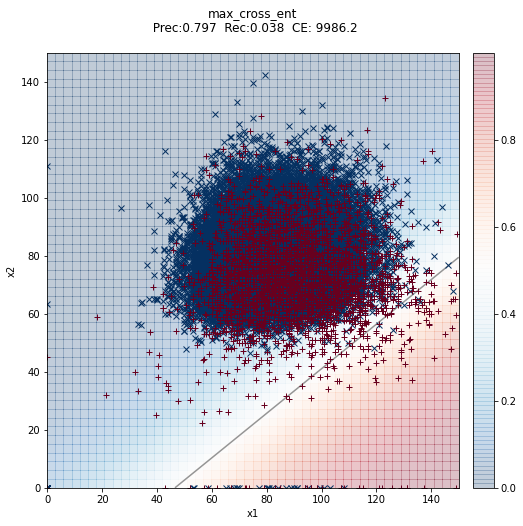

In [54]:
pretty_plot_of_decision_boundary(opt_w_D, level_grid = [0],
                                 figsize=(8,8), title_str='max_cross_ent')
# plt.savefig('decision_boundary_with_min_cross_entropy.png')

In [55]:
np.median(calc_decision_score(train_x_ND, opt_w_D))

-2.468392856763872

## Train Logistic Regression to optimize surrogate losses

- Surrogate loss with the hinge bound is a loose bound on the 0-1 loss
- Surrogate loss with the sigmoid bound is a tighter on the 0-1 loss

In [10]:
## Define functions to calculate the loose and tight bounds

def calculate_hinge_loss(w_D, thresh=0.0):
    return ag_np.maximum(0.0, 1.0-(ag_np.sign(train_y_N-.01)*(ag_np.dot(train_x_ND, w_D[:2]) + w_D[2] - thresh)))

def calculate_fp_upper_bound_loose(w_D, thresh=0.0):
    '''
    Calculate false positive upper bound with hinge loss only on negative examples 
    '''
    return ag_np.sum(calculate_hinge_loss(w_D, thresh=thresh)[train_y_N==0])

def calculate_tp_lower_bound_loose(w_D, thresh=0.0):
    '''
    Calculate true positive lower bound with hinge loss only on positive examples
    '''
    return ag_np.sum(1-(calculate_hinge_loss(w_D, thresh=thresh)[train_y_N==1]))

def calculate_sigmoid_loss(w_D, thresh=0.0):
    return 2.2*ag_expit(-(ag_np.sign(train_y_N-.01)*(ag_np.dot(train_x_ND, w_D[:2]) + w_D[2] - thresh)))

def calculate_fp_upper_bound_tight(w_D, thresh=0.0):
    '''
    Calculate false positive upper bound with sigmoid loss only on negative examples 
    '''
    return ag_np.sum(calculate_sigmoid_loss(w_D, thresh=thresh)[train_y_N==0])

def calculate_tp_lower_bound_tight(w_D, thresh=0.0):
    '''
    Calculate true positive lower bound with sigmoid loss only on positive examples
    '''
    return ag_np.sum(1-(calculate_sigmoid_loss(w_D, thresh=thresh)[train_y_N==1]))


def calculate_surrogate_loss(w_D, thresh=0.0, lamb=1.0, alpha=0.9, loose_bounds=True):
    frac_alpha=alpha/(1-alpha)
    if loose_bounds==True:
        return -calculate_tp_lower_bound_loose(w_D, thresh=thresh)*(1+lamb) + \
                                                    lamb*frac_alpha*calculate_fp_upper_bound_loose(w_D, thresh=thresh)
    else:
        return -calculate_tp_lower_bound_tight(w_D, thresh=thresh)*(1+lamb) + \
                                                    lamb*frac_alpha*calculate_fp_upper_bound_tight(w_D, thresh=thresh)


grad_surrogate_loss = autograd.grad(calculate_surrogate_loss)

## Plot the decision boundary and performance metrics obtained by optimizing surrogate loss with loose bounds

- Recall is poor when maximizing Recall at fixed precision=0.85, when the bounds are loose

5 6 11
thr  0.000 | cross_entropy 257.782 | precision 0.895 | recall 0.760 | TP   171 | FP    20 | TN   320 | FN    54


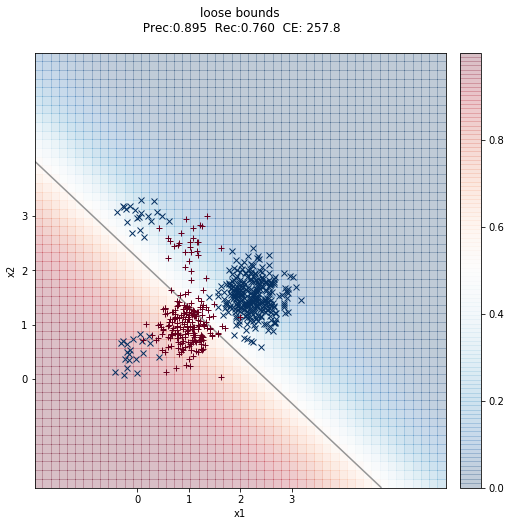

In [11]:
## Optimize using the loose bounds
ans = scipy.optimize.minimize(
    fun=calculate_surrogate_loss,
    x0=opt_w_D,
    jac=grad_surrogate_loss,
    args=(0.0, 1.0, 0.85, True),
    method='L-BFGS-B')

opt_w_D_surr_loose = ans.x

pretty_plot_of_decision_boundary(opt_w_D_surr_loose, level_grid = [0.0],
                                 figsize=(8,8), title_str='loose bounds')

plt.savefig('decision_boundary_with_loose_bounds.png')

## Plot the decision boundary and performance metrics obtained by optimizing surrogate loss with tight bounds

- Recall is better when maximizing recall at fixed precision=0.85 when the bounds are tight

5 6 11
thr  0.000 | cross_entropy 1796.016 | precision 0.902 | recall 0.862 | TP   194 | FP    21 | TN   319 | FN    31


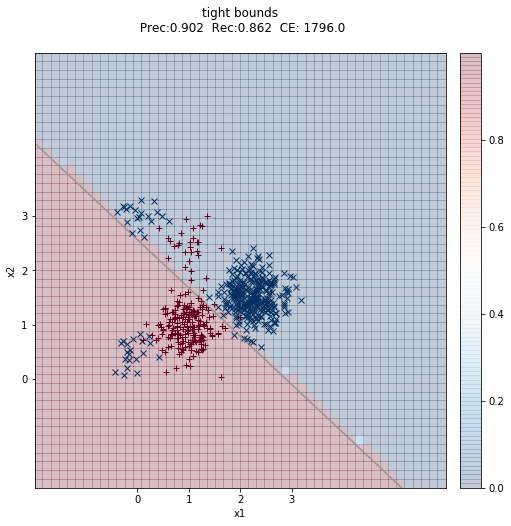

In [12]:
## Optimize with tighter bounds
ans = scipy.optimize.minimize(
    fun=calculate_surrogate_loss,
    x0=opt_w_D,
    jac=grad_surrogate_loss,
    args=(0.0, 1.0, 0.85, False),
    method='L-BFGS-B')

opt_w_D_surr_tight = ans.x
pretty_plot_of_decision_boundary(opt_w_D_surr_tight, level_grid = [0.0],
                                 figsize=(8,8), title_str='tight bounds')

plt.savefig('decision_boundary_with_tight_bounds.png')

## Forcing the precision to be > 0.95 with the tight bound results in the classifier predicting most examples as positives

- Need to be careful when selecting the fixed precision?

5 6 11
thr  0.000 | cross_entropy 7598.531 | precision 1.000 | recall 0.022 | TP     5 | FP     0 | TN   340 | FN   220


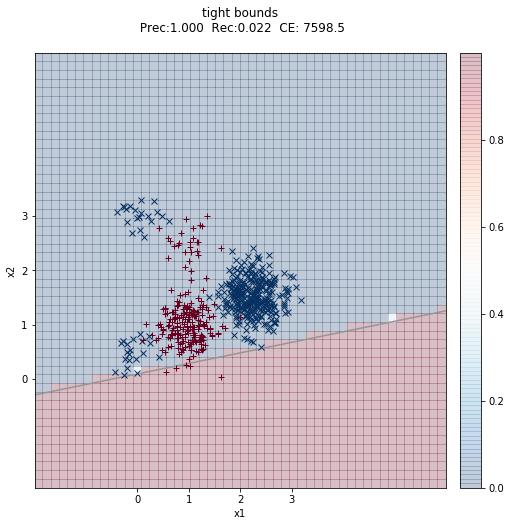

In [13]:
## Force fixed precision > 0.95 by increasing lambda
ans = scipy.optimize.minimize(
    fun=calculate_surrogate_loss,
    x0=opt_w_D,
    jac=grad_surrogate_loss,
    args=(0.0, 10.0, 0.95, False),
    method='L-BFGS-B')

w_D_debug = ans.x

pretty_plot_of_decision_boundary(w_D_debug, level_grid = [0.0],
                                 figsize=(8,8), title_str='tight bounds')

## Plot the decision boundary when maximizing with max recall only

- We expect all the samples to predicted as positives

5 6 11
thr  0.000 | cross_entropy 8705.914 | precision 0.398 | recall 1.000 | TP   225 | FP   340 | TN     0 | FN     0


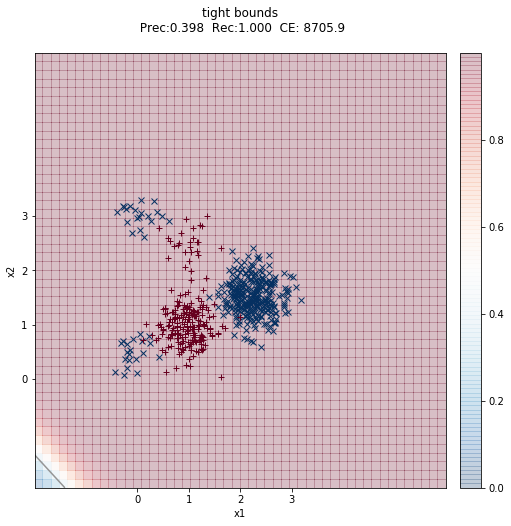

In [14]:
## Optimize just maximizing recall
ans = scipy.optimize.minimize(
    fun=calculate_surrogate_loss,
    x0=opt_w_D,
    jac=grad_surrogate_loss,
    args=(0.0, 1.0, 0.0, False),
    method='L-BFGS-B')

opt_w_D_max_recall_only = ans.x

pretty_plot_of_decision_boundary(opt_w_D_max_recall_only, level_grid = [0.0],
                                 figsize=(8,8), title_str='tight bounds')

## Plot 0-1, hinge(loose) and sigmoid(tight) bounds for negative samples

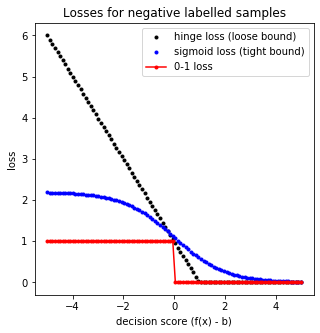

In [59]:
f, axs = plt.subplots(1, 1, figsize=(5,5))

scores = np.linspace(-5, 5, 100)
hinge_loss = ag_np.maximum(0.0, 1.0-(scores))
sigmoid_loss = 2.2*ag_expit(-(scores))
loss_0_1 = (scores<=0)*1.0

axs.plot(scores, hinge_loss, 'k.', label='hinge loss (loose bound)')
axs.plot(scores, sigmoid_loss, 'b.', label='sigmoid loss (tight bound)')
axs.plot(scores, loss_0_1, 'r.-', label='0-1 loss')
axs.set_xlabel('decision score (f(x) - b)')
axs.set_ylabel('loss')
axs.set_title('Losses for negative labelled samples')
axs.legend()
plt.show()

f.savefig('loss_bounds_with_tight.png')